#Imports and GPU Configuration

In [1]:
import sionna

import tensorflow as tf
tf.random.set_seed(1) # Set global random seed for reproducibility
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as patches

from sionna import PI
from sionna.rt import load_scene, Transmitter, Receiver, RIS, PlanarArray, \
                      r_hat, normalize, Camera

#Load Cape town scene

In [2]:
scene = load_scene("cape_town/cape_town.xml")

#Configure the Scene
We set up a 3D wireless communication scene at 3.5 GHz with a transmitter, two receivers, and a reconfigurable intelligent surface (RIS) with 100×100 elements. The RIS optimizes signal coverage by applying a phase gradient reflector to enhance propagation toward defined target areas, enabling coverage map visualization.

In [87]:
scene.frequency = 3.5e9 # Carrier frequency [Hz]
scene.tx_array = PlanarArray(1,1,0.5,0.5,"iso", "V")
scene.rx_array = PlanarArray(1,1,0.5,0.5,"iso", "V")
# Place a transmitter
tx = Transmitter("tx", position=[-92,3,33], look_at=[0,0,0])
scene.add(tx)

rx = Receiver("rx", position=[-77,-40,1.5])
rx1 = Receiver("rx1", position=[-31,-41,1.5])
scene.add(rx)
scene.add(rx1)
# RIs
ris = RIS(name="ris",
          position=[-20,-15,40],
          orientation=[PI/4-PI,0,0],
          num_rows=100,
          num_cols=100,
          num_modes=2,)
scene.add(ris)
tx.look_at(ris)

sources = [tx.position, tx.position]
targets = [rx.position, rx1.position]
ris.phase_gradient_reflector(sources, targets)
target_center = np.array([-77,-40,1.5]) # Center
target_size = np.array([10.,10.]) # Size
cm_cell_size = [1, 1]  # Cell size of the coverage map
cm_center = np.array([-60, -10, 1.5])  # Center of the coverage map
cm_size = np.array([150, 150])  # Size of the coverage map
target_center2 = np.array([-31,-41,1.5]) # Center
target_size2 = np.array([10.,10.]) # Size

This code generates a coverage map without considering the RIS, using 10 million rays and including line-of-sight, reflection, diffraction, and scattering effects. The map parameters define its resolution, center, size, and orientation for visualizing signal propagation in the scene.

In [89]:
cm_no_ris = scene.coverage_map(num_samples=10e6, #increase for better resolution
                        max_depth=6,
                        los=True,
                        reflection=True,
                        diffraction=True,
                        scattering=True,
                        ris=False,
                        cm_cell_size=[1,1],
                        cm_orientation=[0,0,0],
                        cm_center=cm_center,
                        cm_size=cm_size, check_scene=False)

Let us define the amplitude of the RIS reradiation modes as a changable variable. The constraint ensures that the values are clipped to this range during optimization or updates. 

In [90]:
m1 = tf.Variable([0.1, 0.9], dtype=tf.float32,
                 constraint=lambda x: tf.clip_by_value(x, 0.01, 1))

#Learn Radio Material Properties by Gradient Descent
Now we want to optimize the RIS amplitude profile using a gradient-based approach to balance path gains between two target areas. The training loop iteratively adjusts the amplitude profile by minimizing the difference in path gains (in dB) computed from coverage maps of the target regions.


In [93]:
optimizer = tf.keras.optimizers.Adam(0.005)
def to_db(x):
    return 10*tf.math.log(x)/tf.math.log(10.)
num_steps = 100

def train_step():
    """A single training step"""
    with tf.GradientTape() as tape:
        ris.amplitude_profile.mode_powers = m1 / tf.reduce_sum(m1)
        # Compute coverage of the target area
        target_cm = scene.coverage_map(num_samples=10e6, #increase for better resolution
                                       max_depth=6, 
                                       cm_center=target_center,
                                       cm_orientation=[0,0,0], 
                                       cm_size=target_size, # Target area 
                                       cm_cell_size=cm_cell_size,
                                       diffraction=True, scattering=True, ris=True, # Enable diffraction and scattering in addition to reflection and LoS
                                       check_scene=False) # Don't check the scene prior to compute to speed things up
        # The loss function is a rate in bit
        target_cm2 = scene.coverage_map(num_samples=10e6, #increase for better resolution
                                       max_depth=6, 
                                       cm_center=target_center2,
                                       cm_orientation=[0,0,0], 
                                       cm_size=target_size2, # Target area 
                                       cm_cell_size=cm_cell_size,
                                       diffraction=True, scattering=True, ris=True, # Enable diffraction and scattering in addition to reflection and LoS
                                       check_scene=False)
        # We fix an arbitrary scaling factor corresponding to the transmit to noise power ratio
        # The scaling has a direct impact the gradient magnitudes
        #scaling = 1e6
        path_gain1 = to_db(tf.reduce_mean(target_cm.as_tensor()))
        path_gain2 = to_db(tf.reduce_mean(target_cm2.as_tensor()))
        loss = tf.abs(path_gain1 - path_gain2) 
    
    # Compute gradients and apply through the optimizer
    grads = tape.gradient(loss, tape.watched_variables())
    optimizer.apply_gradients(zip(grads, tape.watched_variables()))
    return path_gain1, path_gain2
path_gain1_list = []
path_gain2_list = []


for step in range(num_steps):       
    path_gain1, path_gain2 = train_step()
    path_gain1_list.append(path_gain1.numpy())
    path_gain2_list.append(path_gain2.numpy())
    print(f"Training step {step} - Rate: {path_gain1.numpy():.2f}dB, Path gain 2: {path_gain2.numpy():.2f}dB - Amplitude values: {m1 / tf.reduce_sum(m1).numpy()}")

Training step 0 - Rate: -104.54dB, Path gain 2: -89.96dB - Amplitude values: [0.10499997 0.89500004]
Training step 1 - Rate: -104.48dB, Path gain 2: -90.06dB - Amplitude values: [0.10999484 0.8900052 ]
Training step 2 - Rate: -103.50dB, Path gain 2: -90.12dB - Amplitude values: [0.11499798 0.885002  ]
Training step 3 - Rate: -102.84dB, Path gain 2: -90.14dB - Amplitude values: [0.12000754 0.8799925 ]
Training step 4 - Rate: -103.41dB, Path gain 2: -90.21dB - Amplitude values: [0.12500374 0.87499624]
Training step 5 - Rate: -102.91dB, Path gain 2: -90.24dB - Amplitude values: [0.12999272 0.8700073 ]
Training step 6 - Rate: -102.45dB, Path gain 2: -90.21dB - Amplitude values: [0.13497646 0.86502355]
Training step 7 - Rate: -102.18dB, Path gain 2: -90.37dB - Amplitude values: [0.13995287 0.8600471 ]
Training step 8 - Rate: -102.17dB, Path gain 2: -90.43dB - Amplitude values: [0.14491665 0.85508335]
Training step 9 - Rate: -101.65dB, Path gain 2: -90.46dB - Amplitude values: [0.14987108 0.

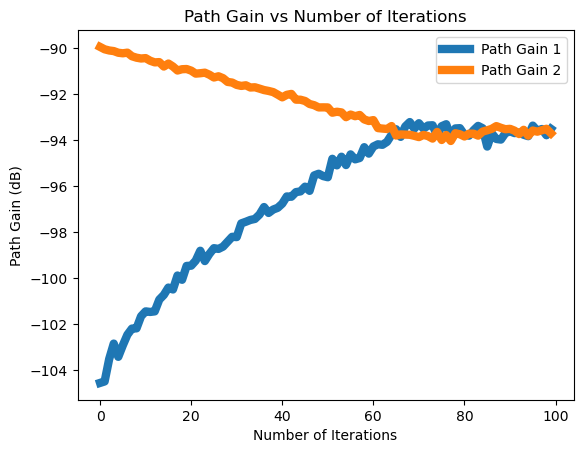

In [108]:
fig1 = plt.figure()
plt.plot(range(num_steps), path_gain1_list, label='Path Gain 1', linewidth=6)
plt.plot(range(num_steps), path_gain2_list, label='Path Gain 2', linewidth=6)
plt.xlabel('Number of Iterations')
plt.ylabel('Path Gain (dB)')
plt.title('Path Gain vs Number of Iterations')
plt.legend()
plt.show()
fig1.savefig('iteration1.png', dpi=600, bbox_inches='tight')

Now one can see that after 100 iterations, the path gain of area 1 and area 2 are converged together. The amplitude of the RIS reradiation modes are [0.41083437 0.5891657 ]. Now let us calculate the new coverage maps and the gain. 

In [96]:
cm_new = scene.coverage_map(num_samples=10e6, #increase for better resolution
                        max_depth=6,
                        los=True,
                        reflection=True,
                        diffraction=True,
                        scattering=True,
                        ris=True,
                        cm_cell_size=[1,1],
                        cm_orientation=[0,0,0],
                        cm_center=cm_center,
                        cm_size=cm_size, check_scene=False)

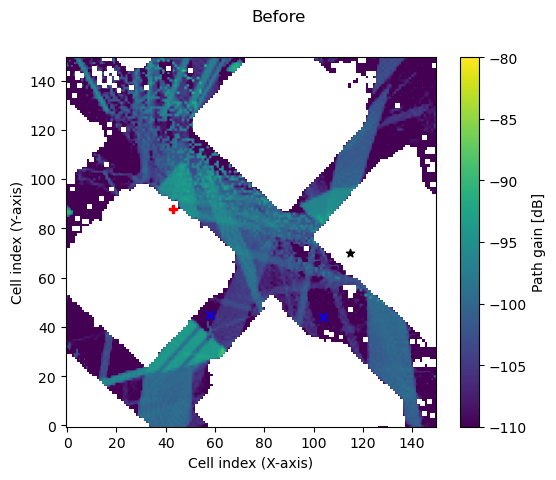

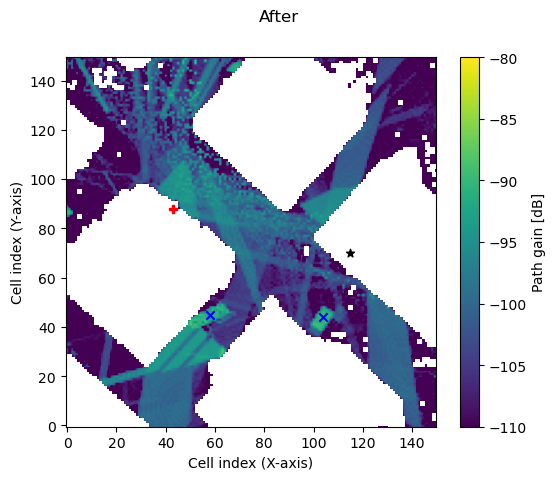

In [160]:

fig3 = cm_no_ris.show(vmin=-110, vmax=-80, show_ris=True, show_rx=True)
fig3.suptitle("Before")
fig3.savefig('CMbefore.png', dpi=600, bbox_inches='tight')

# Display the optimized coverage map
fig4 = cm_new.show(vmin=-110, vmax=-80, show_ris=True, show_rx=True)
fig4.suptitle("After")
fig4.savefig('CMafter.png', dpi=600, bbox_inches='tight')

C:\Users\mjava\AppData\Local\Temp\ipykernel_9840\4105211170.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(10*np.log10(cm_new._value[0]/cm_no_ris._value[0]), cmap=cmap, origin='lower', vmin=0, vmax=25)


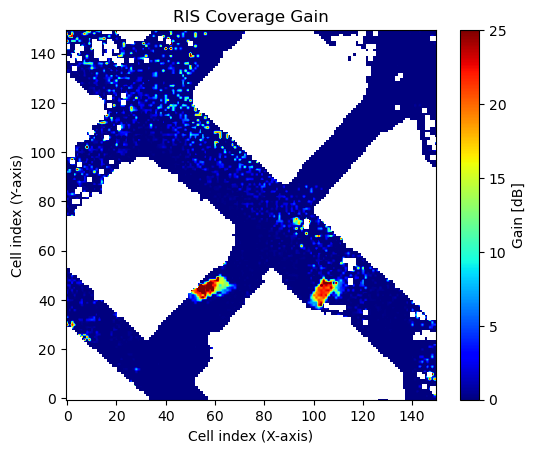

In [114]:
colormaps = ['jet']
for cmap in colormaps:
    fig5 = plt.figure()
    plt.imshow(10*np.log10(cm_new._value[0]/cm_no_ris._value[0]), cmap=cmap, origin='lower', vmin=0, vmax=25)
    plt.colorbar(label='Gain [dB]')
    plt.xlabel('Cell index (X-axis)');
    plt.ylabel('Cell index (Y-axis)');
    plt.title("RIS Coverage Gain");
    fig5.savefig('Gain.png', dpi=1200, bbox_inches='tight')